Startegy
--------

Since the data seems to be well distributed, we will use nfold cv for validation and a startified sample from the train set. The startified sample should contain all types of ghosts with 5 samples from each color category.

In [1]:
import xgboost as xgb
import pandas as pd

In [2]:
%matplotlib inline

In [3]:
train_data = pd.read_csv('data/train.csv', low_memory=False)
test_data = pd.read_csv('data/test.csv', low_memory=False)

In [4]:
combined_set = pd.concat([train_data, test_data])

In [16]:
# add the combined var
combined_set['combined_var'] = (combined_set.hair_length * .40) + (combined_set.has_soul * .40)

In [17]:
# Replace categorical variables with numbers
def label_encoding(df, col):
    label_map = { key: float(n) for n, key in enumerate(df[col].unique()) }
    label_reverse_map = { label_map[key]: key for key in label_map }
    df[col] = df[col].apply(lambda x: label_map[x])
    return df, label_map, label_reverse_map

combined_set, _, _ = label_encoding(combined_set, 'color')

In [18]:
combined_set.corr()

,bone_length,color,hair_length,has_soul,id,rotting_flesh,combined_var
bone_length,1.000000,0.028975,0.391096,0.389710,-0.055528,-0.036473,0.452152
color,0.028975,1.000000,-0.060351,-0.013871,0.034124,0.050644,-0.042430
hair_length,0.391096,-0.060351,1.000000,0.490707,-0.001244,-0.198511,0.857220
has_soul,0.389710,-0.013871,0.490707,1.000000,0.026444,-0.157359,0.869332
id,-0.055528,0.034124,-0.001244,0.026444,1.000000,0.051417,0.014922
rotting_flesh,-0.036473,0.050644,-0.198511,-0.157359,0.051417,1.000000,-0.205597
combined_var,0.452152,-0.042430,0.857220,0.869332,0.014922,-0.205597,1.000000


In [19]:
train_set = combined_set[:len(train_data.index)]

In [20]:
test_set = combined_set[len(train_data.index):]

In [21]:
len(train_set.index), len(train_data.index), len(test_data.index), len(test_set.index)

(371, 371, 529, 529)

In [22]:
train_set, type_label_map, type_label_reverse_map = label_encoding(train_set, 'type')

/home/jayant/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [23]:
type_label_map

{'Ghost': 2.0, 'Ghoul': 0.0, 'Goblin': 1.0}

In [24]:
train_cols = ['combined_var', 'rotting_flesh', 'bone_length', 'has_soul']
target_var = 'type'
selected_cols = train_cols + [target_var]

In [25]:
train_set[selected_cols].head()

,combined_var,rotting_flesh,bone_length,has_soul,type
0,0.498761,0.350839,0.354512,0.781142,0.0
1,0.388520,0.425868,0.575560,0.439899,1.0
2,0.641136,0.354330,0.467875,0.791225,0.0
3,0.608492,0.508723,0.776652,0.884464,0.0
4,0.422013,0.875862,0.566117,0.636438,2.0


In [26]:
dtrain = xgb.DMatrix(train_set[train_cols], feature_names=train_cols, label=train_set[target_var])
dtest = xgb.DMatrix(test_set[train_cols], feature_names=train_cols)

In [27]:
params = {'max_depth':5, 'eta':0.0001, 'silent':1, 'objective':'multi:softmax'}
params['num_class'] = 3
params['seed'] = 7
params['subsample'] = 0.6
params['gamma'] = 4
params['min_child_weight'] = 0
params['tree_method'] = 'exact'
params['sketch_eps'] = 0.4

In [28]:
xgb.cv(params, dtrain, nfold=10, num_boost_round=100)

/home/jayant/anaconda3/lib/python3.5/site-packages/xgboost/training.py:272: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  idset = [randidx[(i * kstep): min(len(randidx), (i + 1) * kstep)] for i in range(nfold)]


,test-merror-mean,test-merror-std,train-merror-mean,train-merror-std
0,0.312802,0.060012,0.247675,0.015088
1,0.299217,0.059847,0.230907,0.014863
2,0.291038,0.050514,0.230597,0.017898
3,0.288407,0.043581,0.226110,0.014724
4,0.307254,0.036372,0.227906,0.016067
5,0.317923,0.036362,0.224013,0.016422
6,0.307254,0.029743,0.219226,0.017270
7,0.304552,0.036005,0.215330,0.019333
8,0.291038,0.039102,0.218626,0.017580
9,0.280227,0.043141,0.215034,0.014585


In [31]:
model = xgb.train(params, dtrain, num_boost_round=50)

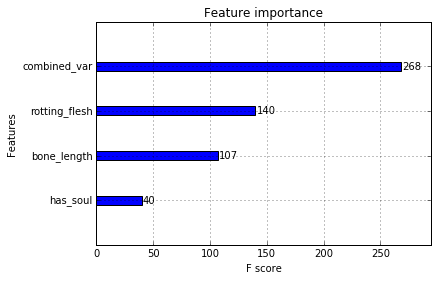

In [32]:
xgb.plot_importance(model)

In [114]:
predictions = model.predict(dtest)

In [115]:
sub = pd.DataFrame({'id': test_set.id, 'type': predictions})
sub['type'] = sub.type.apply(lambda x: type_label_reverse_map[x])

In [116]:
sub.to_csv('submission5_model.csv', index=False)

In [234]:
sub.head()

,id,type
0,3,Ghoul
1,6,Goblin
2,9,Ghoul
3,10,Goblin
4,13,Ghost


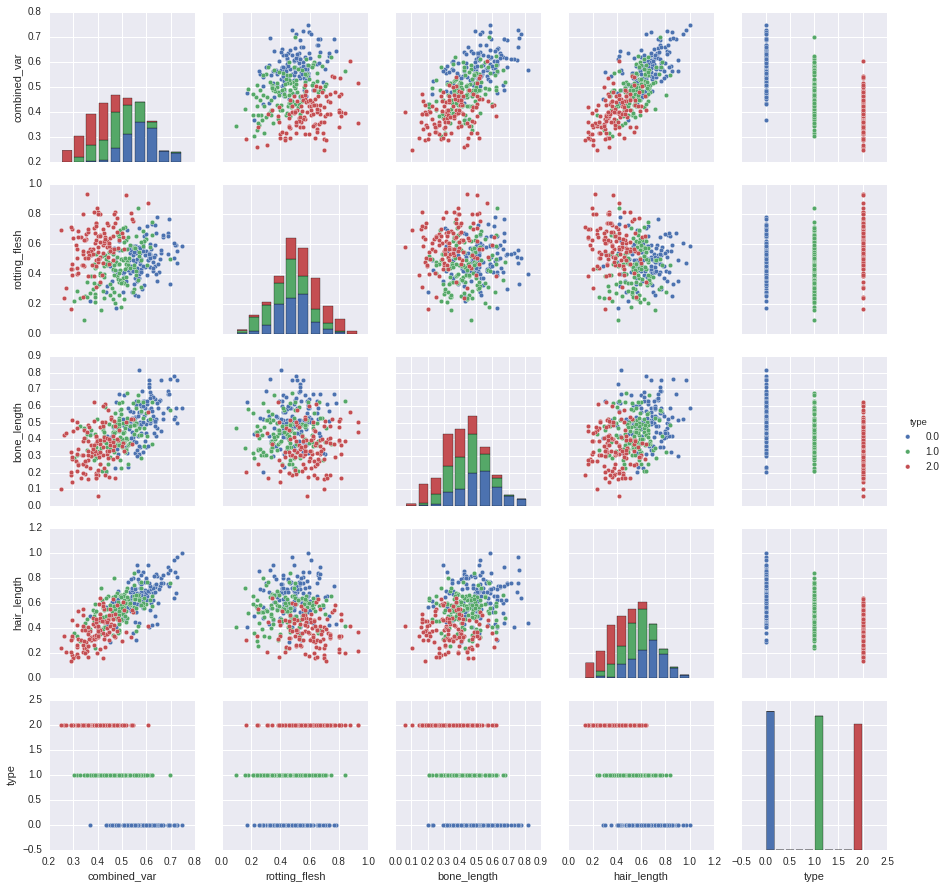

In [38]:
import seaborn as sns
sns.set()

sns.pairplot(train_set[selected_cols], hue='type')

In [39]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [60]:
train, val = train_test_split(train_set[selected_cols], stratify = train_set[target_var])

dtrain_partial = xgb.DMatrix(train[train_cols], feature_names=train_cols, label=train[target_var])
dval = xgb.DMatrix(val[train_cols], feature_names=train_cols, label=val[target_var])

In [61]:
watchlist = [(dval, 'eval'), (dtrain_partial, 'train')]
model_2 = xgb.train(params, dtrain_partial, 60, watchlist)

[0]	eval-merror:0.430108	train-merror:0.352518
[1]	eval-merror:0.268817	train-merror:0.291367
[2]	eval-merror:0.301075	train-merror:0.287770
[3]	eval-merror:0.301075	train-merror:0.287770
[4]	eval-merror:0.322581	train-merror:0.248201
[5]	eval-merror:0.344086	train-merror:0.262590
[6]	eval-merror:0.344086	train-merror:0.258993
[7]	eval-merror:0.344086	train-merror:0.258993
[8]	eval-merror:0.344086	train-merror:0.258993
[9]	eval-merror:0.344086	train-merror:0.262590
[10]	eval-merror:0.322581	train-merror:0.269784
[11]	eval-merror:0.301075	train-merror:0.262590
[12]	eval-merror:0.279570	train-merror:0.255396
[13]	eval-merror:0.301075	train-merror:0.262590
[14]	eval-merror:0.301075	train-merror:0.262590
[15]	eval-merror:0.290323	train-merror:0.262590
[16]	eval-merror:0.268817	train-merror:0.258993
[17]	eval-merror:0.279570	train-merror:0.255396
[18]	eval-merror:0.268817	train-merror:0.266187
[19]	eval-merror:0.279570	train-merror:0.258993
[20]	eval-merror:0.301075	train-merror:0.266187
[2

In [62]:
model_2.predict(dval)

array([ 1.,  2.,  0.,  0.,  0.,  0.,  1.,  0.,  2.,  1.,  1.,  2.,  0.,
        2.,  1.,  2.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  2.,
        0.,  1.,  1.,  1.,  0.,  0.,  2.,  0.,  1.,  2.,  2.,  1.,  2.,
        0.,  1.,  0.,  1.,  1.,  2.,  1.,  1.,  1.,  2.,  2.,  0.,  0.,
        0.,  2.,  0.,  2.,  2.,  0.,  2.,  2.,  1.,  2.,  2.,  1.,  0.,
        0.,  2.,  1.,  2.,  0.,  0.,  1.,  1.,  2.,  0.,  1.,  1.,  0.,
        1.,  1.,  0.,  2.,  0.,  0.,  0.,  0.,  2.,  1.,  0.,  2.,  0.,
        0.,  1.], dtype=float32)

In [63]:
print(classification_report(model_2.predict(dval), dval.get_label()))

             precision    recall  f1-score   support

        0.0       0.76      0.71      0.74        35
        1.0       0.65      0.62      0.63        32
        2.0       0.76      0.85      0.80        26

avg / total       0.72      0.72      0.72        93



In [64]:
type_label_map

{'Ghost': 2.0, 'Ghoul': 0.0, 'Goblin': 1.0}

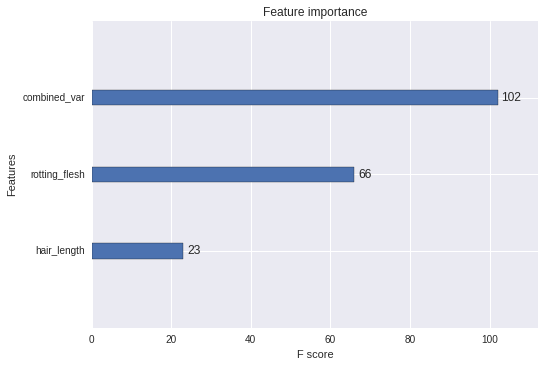

In [65]:
xgb.plot_importance(model_2)

In [66]:
predictions = model_2.predict(dtest)
sub = pd.DataFrame({'id': test_set.id, 'type': predictions})
sub['type'] = sub.type.apply(lambda x: type_label_reverse_map[x])
sub.to_csv('submission5_model2.csv', index=False)

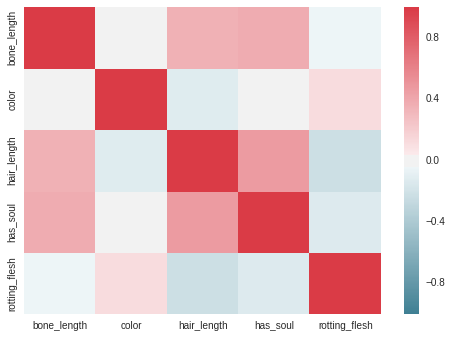

In [82]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(train_set[['bone_length', 'color', 'hair_length', 'has_soul', 'rotting_flesh']].corr(),
            cmap=cmap)